# 데이터 분석 절차

1. 기획 (주가 예측 - 어떤걸? 에코프로)
2. 데이터 수집 (크롤링, 라이브러리, 다운로드, API)
3. 데이터 EDA, 전처리 (가공)
4. 모델링 (어떤 모델을 사용할 것인지 - 데이터셋을 보고. 머신vs딥, 분류vs회귀)
5. 학습
6. 평가 (테스트)

## 데이터 수집

In [ ]:
%pip install -U Finance-DataReader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
df_krx = fdr.StockListing('KRX')

In [ ]:
df_krx[df_krx['Name'] == '삼성전자'] # 086520

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,69900,2,-500,-0.71,70000,70500,69900,10115689,708954272100,417287800245000,5969782550,STK


In [ ]:
df = fdr.DataReader('005930', '2017-01-01', '2021-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-12-24,80200,80800,80200,80500,12086380,0.007509
2021-12-27,80600,80600,79800,80200,10783368,-0.003727
2021-12-28,80200,80400,79700,80300,18226325,0.001247
2021-12-29,80200,80200,78500,78800,19794795,-0.018680
2021-12-30,78900,79500,78100,78300,14236700,-0.006345


## 데이터 가공

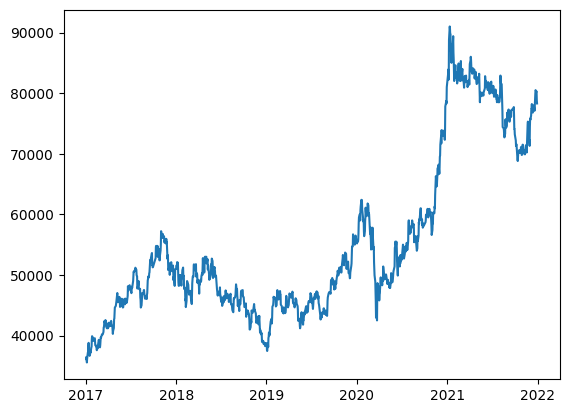

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df['Close'])
plt.show()

In [ ]:
# 정규화 (Standard Scaler)
scaled_x = (df['Close'] - df['Close'].mean()) / df['Close'].std()

# # 정규화 (Min-Max Scaler) -> 값의 범위가 작을때 이를 확장
# min_value = df['Close'].min()
# max_value = df['Close'].max()
# scaled_x = (df['Close'] - min_value) / (max_value - min_value)

# # 정규화 (Robust Scaler) -> 이상치 포함된 데이터
# from sklearn.preprocessing import RobustScaler
# scaled_x = RobustScaler().fit_transform(df['Close'].to_numpy().reshape(-1, 1))

In [ ]:
# plt.hist(s_scaled_x, bins=40) # 1371, 1
# plt.show()

In [ ]:
# 데이터 전처리 (5일치로 자르기)
import numpy as np
# X = np.array([])
# y = np.array([])
X = np.array([
    [
        scaled_x[i+j] for j in range(5) # 5일치 seq로 잡아줌 0일+0day, 0일+1day, ..., 0일 + 4day
        ] for i in range(len(scaled_x)-6) # 데이터 범위 잡아주는 반복문
    ])
y = np.array([
    scaled_x[i+5]  # 0+5day => target date
    for i in range(len(scaled_x)-6) # 범위
    ])

In [ ]:
X.shape, y.shape

((1223, 5), (1223,))

In [ ]:
# 학습 데이터 분리 (앞 80%, 뒤 20%)
train_idx = int( len(X) * 0.7 )

In [ ]:
train_idx

856

In [ ]:
X_train = X[:train_idx]
y_train = y[:train_idx]
X_test = X[train_idx:]
y_test = y[train_idx:]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((856, 5), (856,), (367, 5), (367,))

In [ ]:
# 데이터셋, 데이터로더 정의
import torch
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).reshape(-1, 5, 1)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32)

## 모델링

- GRU

- xgboost

In [ ]:
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=8, num_layers=2, batch_first=True)
        self.fc = nn.Linear(8, 1)
        return

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])

        return output

model = StockLSTM()

In [ ]:
# 컴파일
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), lr=0.25)
criterion = nn.MSELoss().cuda() # .cuda() - gpu설정
scheduler = StepLR(optimizer, step_size=30, gamma=0.7)

## 학습

- 큰 반복문: epochs
- 작은 반복문: train_loader


In [ ]:
epochs = 50
train_loss = []
for epoch in range(epochs):
    train_loss = []
    model.train() # 학습모드로 변경

    for data, label in train_loader:
        data, label = data.to(device), label.to(device)

        # 딥러닝 모델 학습시키는 순서는??
        # 1. model output -> Feed Forward
        # 2. loss 계산 (real, output)
        # 3. back propagation (역전파)

        optimizer.zero_grad() # 기존의 계산했었던 기울기 초기화
        output = model(data) # 1
        # print(output.shape, label.shape)

        loss = criterion(output, label) # 2
        train_loss.append(loss.item())
        # 3
        loss.backward()
        optimizer.step()
    _train_loss = np.mean(train_loss)
    train_loss.append(_train_loss)

    print('[{}/{}] Train Loss {:.6f}'.format(epoch+1, epochs, _train_loss))

    scheduler.step()


[1/50] Train Loss 0.237966
[2/50] Train Loss 0.435449
[3/50] Train Loss 0.196289
[4/50] Train Loss 0.208818
[5/50] Train Loss 0.215238
[6/50] Train Loss 0.217829
[7/50] Train Loss 0.218984
[8/50] Train Loss 0.219216
[9/50] Train Loss 0.204517
[10/50] Train Loss 0.169188
[11/50] Train Loss 0.125520
[12/50] Train Loss 0.098701
[13/50] Train Loss 0.119697
[14/50] Train Loss 0.115286
[15/50] Train Loss 0.100378
[16/50] Train Loss 0.098726
[17/50] Train Loss 0.075742
[18/50] Train Loss 0.134553
[19/50] Train Loss 0.099936
[20/50] Train Loss 0.102223
[21/50] Train Loss 0.092538
[22/50] Train Loss 0.112008
[23/50] Train Loss 0.089302
[24/50] Train Loss 0.062970
[25/50] Train Loss 0.078231
[26/50] Train Loss 0.088968
[27/50] Train Loss 0.083832
[28/50] Train Loss 0.067104
[29/50] Train Loss 0.068676
[30/50] Train Loss 0.085101
[31/50] Train Loss 0.054440
[32/50] Train Loss 0.046987
[33/50] Train Loss 0.051239
[34/50] Train Loss 0.064590
[35/50] Train Loss 0.065291
[36/50] Train Loss 0.058189
[

## 검증 (예측)

In [ ]:
# 예측 결과, 실제값 담을 곳
y_pred = torch.Tensor([])
y_real = torch.Tensor([])

model.eval()
for data, label in test_loader:
    # 모델 테스트 순서? -> Feed Forward
    with torch.no_grad():
        data = data.to(device)
        output = model(data)
        y_pred = torch.cat([y_pred, output.detach().cpu()])
        y_real = torch.cat([y_real, label])

In [ ]:
y_train.max(), y_train.min(), y_test.max(), y_test.min()

(0.518935994340527,
 -1.3636345585670135,
 2.610681053126683,
 -0.19050201510792458)

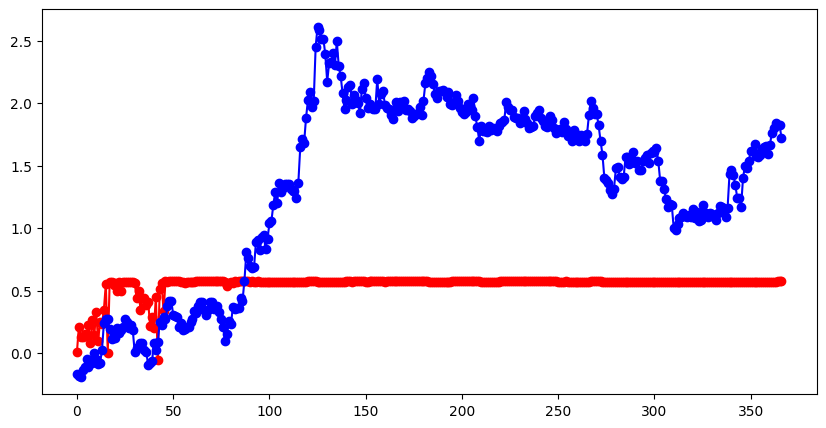

In [ ]:
x_axis = np.arange(0, len(y_pred))

plt.figure(figsize=(10, 5))

plt.plot(x_axis, y_pred, '-o', c='red')
plt.plot(x_axis, y_real, '-o', c='blue')

plt.show()

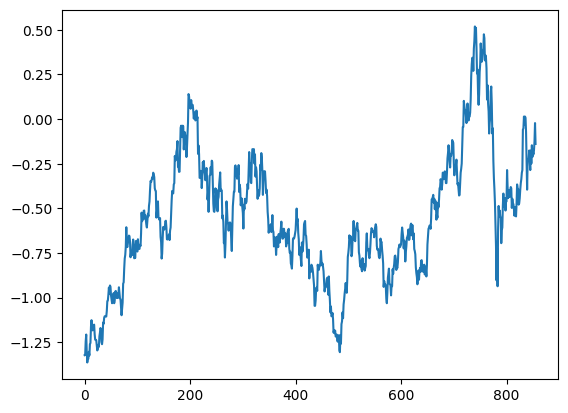

In [ ]:
plt.plot(range(len(y_train)), y_train)
plt.show()

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor()

In [ ]:
X_train.shape

(856, 5)

In [ ]:
y_train.shape

(856,)

In [ ]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

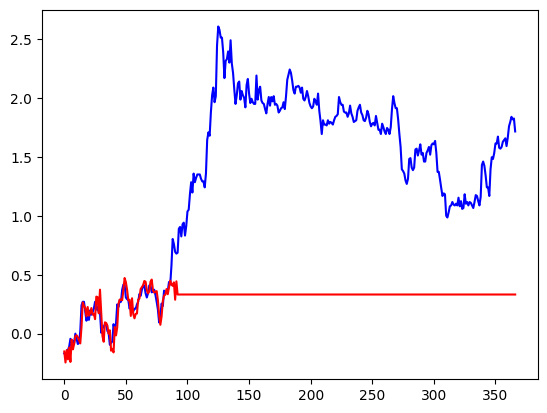

In [ ]:
plt.plot(y_test, c='blue')
plt.plot(y_pred, c='red')
plt.show()